<a href="https://colab.research.google.com/github/debashisdotchatterjee/GBSG2-Breast-Cancer-Epidemiology-01/blob/main/GBSG2_Breast_Cancer_Epidemiology_paper_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Breast Cancer*

Epidemiology Perspective

Epidemiology isn’t limited to infectious diseases — it broadly studies the distribution and determinants of health and disease in populations.

Breast cancer qualifies because:

It has population-level incidence, prevalence, survival, and mortality patterns.

Epidemiologists analyze risk factors (age, hormonal therapy, genetics, environment, parity, BMI).

The GBSG2 dataset directly supports prognostic factor analysis, treatment effects, and outcome modeling — all epidemiologic questions.

📘 Example epidemiologic questions you can ask with GBSG2:

How do hormone receptor status and menopausal state affect survival probability?

What is the population hazard ratio for age or tumor grade?

How have survival outcomes evolved under different therapeutic regimes?

⚕️ 2. Clinical Insight Perspective

From a clinical standpoint:

It links individual-level biomarkers (ER, PR, grade, nodes) with patient outcomes (time to death/censoring).

This bridges bench to bedside translation — identifying prognostic markers, therapy response predictors, and survival heterogeneity.

It reflects the evolving therapeutic landscape, e.g., endocrine therapy, HER2 targeting, and personalized oncology strategies.

🌍 3. Forward-Thinking / Translational Relevance

This dataset aligns perfectly with forward-looking reviews or precision-medicine perspectives:

It allows integrating molecular and clinical data (a hallmark of modern epidemiology).

You can discuss the evolution of survival modeling—from classical Cox regression to modern AI-driven approaches.

It contextualizes population-based precision oncology, where epidemiologic evidence informs clinical decisions.

In [1]:
# --- Install required packages ---
!pip -q install scikit-survival pandas numpy

import pandas as pd
import numpy as np
from sksurv.datasets import load_gbsg2

# 1️⃣ Load the epidemiological / clinical dataset
X, y = load_gbsg2()

# Combine into a single DataFrame
# y is a structured array with ('cens', 'time'), X has clinical features
df = pd.DataFrame(X)
df["event"] = y["cens"]
df["time"] = y["time"]

# 2️⃣ Inspect attributes
print("Shape (rows, columns):", df.shape)
print("\nColumn names:\n", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values by column:\n", df.isna().sum())

# 3️⃣ Print head of the dataset
print("\nData head:")
print(df.head())

# 4️⃣ Save to CSV
csv_path = "GBSG2_epidemiology.csv"
df.to_csv(csv_path, index=False)
print(f"\n✅ Dataset saved to: {csv_path}")

# 5️⃣ Quick metadata summary
print("""
📘 Dataset summary:
German Breast Cancer Study Group (GBSG2)
- 686 women with primary node-positive breast cancer.
- Variables: age, hormonal therapy, tumor size, nodes, progesterone receptor (PR),
  estrogen receptor (ER), menopausal status, grade, etc.
- 'time': follow-up time in days
- 'event': 1 = death, 0 = censored

This dataset is widely used for survival modeling (Cox PH, random survival forests, deep survival models),
and for exploring emerging insights in oncology and personalized medicine.
""")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.3 MB/s eta 0:00:00
Shape (rows, columns): (686, 10)

Column names:
 ['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade', 'tsize', 'event', 'time']

Data types:
 age          float64
estrec       float64
horTh       category
menostat    category
pnodes       float64
progrec      float64
tgrade      category
tsize        float64
event           bool
time         float64
dtype: object

Missing values by column:
 age         0
estrec      0
horTh       0
menostat    0
pnodes      0
progrec     0
tgrade      0
tsize       0
event       0
time        0
dtype: int64

Data head:
    age  estrec horTh menostat  pnodes  progrec tgrade  tsize  event    time
0  70.0    66.0    no     Post 

Python script that implements the full methodology on GBSG2:

Loads data (from your saved GBSG2_epidemiology.csv if present, else from scikit-survival)

Encodes variables (dummies, scaling)

Kaplan–Meier curves (overall and by hormonal therapy)

Cox PH (Efron ties) with HRs, 95% CIs, p-values

PH diagnostics: global and per-covariate tests; Schoenfeld residual plots; log-minus-log curves

Functional form checks: martingale/deviance residuals vs continuous covariates

Baseline hazard/survival and risk-adjusted survival curves for clinical profiles

Predictive performance: C-index; bootstrap optimism-corrected C-index

Penalized Cox (elastic-net) with internal CV (via sksurv Coxnet)

Saves all figures & tables to outputs/figs and outputs/tables, plus a zip GBSG2_outputs.zip

Prints key tables to console for quick copy-paste

In [6]:
# ============================
# Colab setup & dependencies
# ============================
!pip -q install pandas numpy seaborn matplotlib lifelines scikit-survival tabulate scikit-learn

import os, zipfile, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.utils import concordance_index

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tabulate import tabulate

from sksurv.util import Surv
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, brier_score

warnings.filterwarnings("ignore")
sns.set(context="talk", style="whitegrid")

# ============================
# File & output directories
# ============================
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figs")
TAB_DIR = os.path.join(OUT_DIR, "tables")
for d in [OUT_DIR, FIG_DIR, TAB_DIR]:
    os.makedirs(d, exist_ok=True)

def savefig(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()

def save_table(df: pd.DataFrame, name: str):
    csv_path = os.path.join(TAB_DIR, f"{name}.csv")
    xlsx_path = os.path.join(TAB_DIR, f"{name}.xlsx")
    df.to_csv(csv_path, index=False)
    try:
        df.to_excel(xlsx_path, index=False)
    except Exception:
        pass
    return csv_path

# ============================
# Load data
# ============================
csv_path = "GBSG2_epidemiology.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    X, y = load_gbsg2()
    df = pd.DataFrame(X)
    # In sksurv, y["cens"] == True means event (death) occurred.
    df["event"] = y["cens"].astype(bool)
    df["time"] = y["time"].astype(float)

# Clean column names
df.columns = [c.replace(".", "_") for c in df.columns]

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nHead:")
print(df.head())

# ============================
# Basic typing and variable sets
# ============================
cont_vars = [v for v in ["age", "tsize", "pnodes", "estrec", "progrec"] if v in df.columns]
grade_col = "grade" if "grade" in df.columns else ("tgrade" if "tgrade" in df.columns else None)

cat_vars = []
if "horTh" in df.columns: cat_vars.append("horTh")
if "menostat" in df.columns: cat_vars.append("menostat")
if grade_col is not None:   cat_vars.append(grade_col)

for c in cat_vars:
    df[c] = df[c].astype("category")

df = df.dropna(subset=["time", "event"])
df = df[df["time"] > 0]

# ============================
# Kaplan–Meier: overall & by hormonal therapy
# ============================
kmf = KaplanMeierFitter()

fig = plt.figure(figsize=(8,6))
kmf.fit(df["time"], event_observed=df["event"], label="All patients")
kmf.plot(ci_show=True)
plt.title("Kaplan–Meier: Overall Survival")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
savefig(os.path.join(FIG_DIR, "km_overall.png"))

if "horTh" in df.columns and df["horTh"].nunique() > 1:
    fig = plt.figure(figsize=(8,6))
    for grp, sub in df.groupby("horTh"):
        kmf.fit(sub["time"], sub["event"], label=f"horTh={grp}")
        kmf.plot(ci_show=False)
    plt.title("Kaplan–Meier by Hormonal Therapy")
    plt.xlabel("Time (days)"); plt.ylabel("Survival probability")
    savefig(os.path.join(FIG_DIR, "km_by_horTh.png"))

    levels = list(df["horTh"].cat.categories if hasattr(df["horTh"], "cat") else df["horTh"].unique())
    if len(levels) == 2:
        g0 = df[df["horTh"] == levels[0]]
        g1 = df[df["horTh"] == levels[1]]
        lr = logrank_test(g0["time"], g1["time"], event_observed_A=g0["event"], event_observed_B=g1["event"])
        print("\nLogrank test by horTh:")
        print(lr.summary)

# ============================
# Prepare data for CoxPH (lifelines)
# ============================
use_vars = cont_vars + cat_vars
model_df = df[["time", "event"] + use_vars].dropna()

# One-hot encode categoricals (drop first)
model_df = pd.get_dummies(model_df, columns=cat_vars, drop_first=True)

# Scale continuous features
scaler = StandardScaler()
for v in cont_vars:
    if v in model_df.columns:
        model_df[v] = scaler.fit_transform(model_df[[v]])

# Fit Cox PH (Efron ties is default in lifelines), robust SE
cph = CoxPHFitter()
cph.fit(model_df, duration_col="time", event_col="event", robust=True)

print("\n=== Cox PH Summary ===")
cox_summary = cph.summary.reset_index().rename(columns={"index":"covariate"})
print(tabulate(cox_summary, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(cox_summary, "coxph_summary")

# HR table neatly
hr_table = cph.summary.copy()
hr_table["HR"] = np.exp(hr_table["coef"])
hr_table["HR_CI_lower"] = np.exp(hr_table["coef lower 95%"])
hr_table["HR_CI_upper"] = np.exp(hr_table["coef upper 95%"])
hr_table = hr_table[["coef","se(coef)","z","p","HR","HR_CI_lower","HR_CI_upper","exp(coef)"]]
hr_table = hr_table.rename(columns={"exp(coef)":"exp_coef_(=HR_check)"})
print("\n=== Hazard Ratios (exp(coef)) with 95% CI ===")
print(tabulate(hr_table.reset_index().rename(columns={"index":"covariate"}), headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(hr_table.reset_index().rename(columns={"index":"covariate"}), "coxph_HR_table")

# ============================
# PH diagnostics (Schoenfeld)
# ============================
print("\n=== Proportional Hazards tests (Schoenfeld residual-based) ===")
resPH = proportional_hazard_test(cph, model_df, time_transform="rank")
ph_table = resPH.summary.reset_index().rename(columns={"index":"variable"})
print(tabulate(ph_table, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(ph_table, "ph_test_schoenfeld")

# ============================
# Log-minus-log plots (by categorical)
# ============================
def log_minus_log_plot(df_in, time_col, event_col, group_col, fname):
    fig = plt.figure(figsize=(8,6))
    for lvl, sub in df_in.groupby(group_col):
        km = KaplanMeierFitter().fit(sub[time_col], sub[event_col], label=str(lvl))
        s = km.survival_function_.iloc[:, 0].clip(lower=1e-9, upper=1.0)
        t = km.survival_function_.index.values
        plt.plot(np.log(t + 1e-6), np.log(-np.log(s)), label=f"{group_col}={lvl}")
    plt.xlabel("log(Time)"); plt.ylabel("log(-log(S(t)))")
    plt.title(f"Log-minus-log by {group_col}")
    plt.legend()
    savefig(os.path.join(FIG_DIR, fname))

for g in [col for col in ["horTh", "menostat", grade_col] if (col in df.columns and df[col].nunique() > 1)]:
    try:
        log_minus_log_plot(df, "time", "event", g, f"logminuslog_{g}.png")
    except Exception:
        pass

# ============================
# Residuals: martingale & deviance
# ============================
mart_res = cph.compute_residuals(model_df, kind="martingale")
dev_res  = cph.compute_residuals(model_df, kind="deviance")

def save_residuals_long(res_df: pd.DataFrame, value_col_name: str, base_name: str):
    r = res_df.copy().reset_index(names="row")
    if r.shape[1] == 2:
        valcol = [c for c in r.columns if c not in ["row"]][0]
        r = r.rename(columns={valcol: value_col_name})
    else:
        r = r.melt(id_vars=["row"], var_name="var", value_name=value_col_name)
    save_table(r, base_name)
    return r

mart_long = save_residuals_long(mart_res, "martingale_resid", "residuals_martingale_long")
dev_long  = save_residuals_long(dev_res,  "deviance_resid",   "residuals_deviance_long")

for v in cont_vars:
    if v in model_df.columns and v in mart_res.columns:
        fig = plt.figure(figsize=(7,5))
        plt.scatter(model_df[v], mart_res[v], s=12, alpha=0.6)
        sns.regplot(x=model_df[v], y=mart_res[v], lowess=True, scatter=False)
        plt.axhline(0, ls="--", lw=1, c="k")
        plt.title(f"Martingale residuals vs {v} (linearity check)")
        plt.xlabel(f"{v} (scaled)"); plt.ylabel("Martingale residual")
        savefig(os.path.join(FIG_DIR, f"martingale_vs_{v}.png"))

# ============================
# Baseline hazard/survival & profiles
# ============================
fig = plt.figure(figsize=(8,6))
cph.baseline_cumulative_hazard_.plot()
plt.title("Baseline cumulative hazard (Breslow)")
plt.xlabel("Time (days)"); plt.ylabel("H0(t)")
savefig(os.path.join(FIG_DIR, "baseline_cumhaz.png"))

fig = plt.figure(figsize=(8,6))
cph.baseline_survival_.plot()
plt.title("Baseline survival S0(t)")
plt.xlabel("Time (days)"); plt.ylabel("S0(t)")
savefig(os.path.join(FIG_DIR, "baseline_survival.png"))

template = model_df.drop(columns=["time","event"]).median(numeric_only=True).to_frame().T
template = template.reindex(columns=model_df.drop(columns=["time","event"]).columns, fill_value=0)

def set_if_exists(dfX, name, val):
    if name in dfX.columns:
        dfX.loc[:, name] = val

prof_good = template.copy()
set_if_exists(prof_good, "horTh_yes", 1)
set_if_exists(prof_good, "menostat_Pre", 0)
if grade_col: set_if_exists(prof_good, f"{grade_col}_II", 0); set_if_exists(prof_good, f"{grade_col}_III", 0)

prof_bad = template.copy()
set_if_exists(prof_bad, "horTh_yes", 0)
set_if_exists(prof_bad, "menostat_Pre", 1)
if grade_col: set_if_exists(prof_bad, f"{grade_col}_III", 1); set_if_exists(prof_bad, f"{grade_col}_II", 0)

times = np.linspace(model_df["time"].quantile(0.01),
                    model_df["time"].quantile(0.99), 120)

fig = plt.figure(figsize=(8,6))
sf_good = cph.predict_survival_function(prof_good, times=times)  # (len(times), 1) DataFrame
sf_bad  = cph.predict_survival_function(prof_bad , times=times)

x = sf_good.index.to_numpy(dtype=float)     # x-axis from the DF index
y_good = sf_good.iloc[:, 0].to_numpy()      # first (and only) column
y_bad  = sf_bad.iloc[:, 0].to_numpy()

plt.plot(x, y_good, label="Profile A (horTh yes, favorable grade)")
plt.plot(x, y_bad , label="Profile B (horTh no, grade III)")
plt.xlabel("Time (days)")
plt.ylabel("Predicted survival")
plt.title("Risk-adjusted survival: two clinical profiles")
plt.legend()
savefig(os.path.join(FIG_DIR, "predicted_survival_profiles.png"))


# ============================
# Discrimination: C-index
# ============================
ci = concordance_index(event_times=model_df["time"].values,
                       predicted_scores=-cph.predict_partial_hazard(model_df),
                       event_observed=model_df["event"].values)
print(f"\nConcordance index (apparent): {ci:.4f}")

# Bootstrap optimism-corrected C-index (no ties arg)
rng = np.random.default_rng(42)
B = 200
cindex_boot, cindex_test = [], []
for b in range(B):
    idx = rng.integers(0, len(model_df), size=len(model_df))
    boot = model_df.iloc[idx].copy()
    cox_b = CoxPHFitter()
    cox_b.fit(boot, duration_col="time", event_col="event")
    c_app = concordance_index(boot["time"], -cox_b.predict_partial_hazard(boot), boot["event"])
    cindex_boot.append(c_app)
    c_test = concordance_index(model_df["time"], -cox_b.predict_partial_hazard(model_df), model_df["event"])
    cindex_test.append(c_test)

optimism = float(np.mean(cindex_boot) - np.mean(cindex_test))
c_corrected = float(ci - optimism)
cix_df = pd.DataFrame({"C_apparent":[ci], "optimism":[optimism], "C_corrected":[c_corrected]})
print("\nC-index summary:")
print(tabulate(cix_df, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(cix_df, "cindex_summary")

# ============================
# Time-dependent Brier score (using survival probs)
# ============================
y_struct = Surv.from_arrays(event=model_df["event"].astype(bool).values,
                            time=model_df["time"].astype(float).values)

t_grid = np.linspace(np.percentile(model_df["time"], 10),
                     np.percentile(model_df["time"], 90), 25)

surv_mat = []
X_only = model_df.drop(columns=["time","event"])
for i in range(len(model_df)):
    sf = cph.predict_survival_function(X_only.iloc[[i]], times=t_grid)
    surv_mat.append(sf.values.ravel())
surv_mat = np.vstack(surv_mat)

_, bs = brier_score(y_struct, y_struct, surv_mat, t_grid)
brier_df = pd.DataFrame({"time": t_grid, "brier": bs})
print("\nApprox. Integrated Brier Score over grid:",
      np.trapz(bs, t_grid) / (t_grid[-1] - t_grid[0]))
save_table(brier_df, "brier_scores")

fig = plt.figure(figsize=(7,5))
plt.plot(t_grid, bs)
plt.xlabel("Time (days)"); plt.ylabel("Brier score")
plt.title("Time-dependent Brier score (IPCW on same sample)")
savefig(os.path.join(FIG_DIR, "brier_score.png"))

# ============================
# Elastic-net Cox (Coxnet) with CV
# ============================
X_mat = model_df.drop(columns=["time","event"])
scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X_mat)

alphas = [0.1, 0.5, 0.9]
results_en = []
best_model, best_c = None, -np.inf
kf = KFold(n_splits=5, shuffle=True, random_state=123)
for a in alphas:
    fold_cs = []
    for tr, te in kf.split(X_scaled):
        model = CoxnetSurvivalAnalysis(l1_ratio=a)
        model.fit(X_scaled[tr], y_struct[tr])
        c_per_lambda = []
        for lam_idx in range(len(model.alphas_)):
            beta = model.coef_[lam_idx]
            scores = X_scaled[te] @ beta
            c = concordance_index_censored(y_struct[te]["event"], y_struct[te]["time"], -scores)[0]
            c_per_lambda.append(c)
        fold_cs.append(np.max(c_per_lambda))
    avg_c = float(np.mean(fold_cs))
    results_en.append({"l1_ratio": a, "cv_cindex": avg_c})
    if avg_c > best_c:
        best_c = avg_c
        best_model = CoxnetSurvivalAnalysis(l1_ratio=a).fit(X_scaled, y_struct)

en_df = pd.DataFrame(results_en)
print("\nElastic-net Cox (Coxnet) 5-fold CV C-index by l1_ratio:")
print(tabulate(en_df, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(en_df, "coxnet_cv_summary")

if best_model is not None:
    mid_idx = min(len(best_model.alphas_)//2, len(best_model.alphas_)-1)
    beta = pd.Series(best_model.coef_[mid_idx], index=X_mat.columns, name="coef")
    nz = beta[beta.abs() > 1e-8].sort_values(ascending=False)
    nz_df = nz.reset_index().rename(columns={"index":"feature"})
    print("\nElastic-net (example lambda) nonzero coefficients (sorted by magnitude):")
    print(tabulate(nz_df, headers="keys", tablefmt="psql", floatfmt=".4f"))
    save_table(nz_df, "coxnet_nonzero_coef")

# ============================
# Zip all outputs
# ============================
zip_path = "GBSG2_outputs.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUT_DIR):
        for f in files:
            fp = os.path.join(root, f)
            z.write(fp, arcname=os.path.relpath(fp, start=OUT_DIR))
print(f"\nAll outputs saved under '{OUT_DIR}/' and zipped as '{zip_path}'.")

# ============================
# Console recap (paths)
# ============================
print("\nSaved figures:")
for f in sorted(os.listdir(FIG_DIR)):
    print("  -", os.path.join(FIG_DIR, f))

print("\nSaved tables:")
for f in sorted(os.listdir(TAB_DIR)):
    print("  -", os.path.join(TAB_DIR, f))

print("\nZip archive:", zip_path)


Shape: (686, 10)
Columns: ['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade', 'tsize', 'event', 'time']

Head:
    age  estrec horTh menostat  pnodes  progrec tgrade  tsize  event    time
0  70.0    66.0    no     Post     3.0     48.0     II   21.0   True  1814.0
1  56.0    77.0   yes     Post     7.0     61.0     II   12.0   True  2018.0
2  58.0   271.0   yes     Post     9.0     52.0     II   35.0   True   712.0
3  59.0    29.0   yes     Post     4.0     60.0     II   17.0   True  1807.0
4  73.0    65.0    no     Post     1.0     26.0     II   35.0   True   772.0

Logrank test by horTh:
   test_statistic         p  -log2(p)
0        8.564781  0.003427  8.188719

=== Cox PH Summary ===
+----+--------------+---------+-------------+------------+------------------+------------------+-----------------------+-----------------------+----------+---------+--------+------------+
|    | covariate    |    coef |   exp(coef) |   se(coef) |   coef lower 95% |   coef upper 95% | 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 66 is different from 9)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Loaded CSV: GBSG2_epidemiology.csv
Shape: (686, 10)
Columns: ['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade', 'tsize', 'event', 'time']

Head:
    age  estrec horTh menostat  pnodes  progrec tgrade  tsize  event    time
0  70.0    66.0    no     Post     3.0     48.0     II   21.0   True  1814.0
1  56.0    77.0   yes     Post     7.0     61.0     II   12.0   True  2018.0
2  58.0   271.0   yes     Post     9.0     52.0     II   35.0   True   712.0
3  59.0    29.0   yes     Post     4.0     60.0     II   17.0   True  1807.0
4  73.0    65.0    no     Post     1.0     26.0     II   35.0   True   772.0

Logrank test by horTh:
   test_statistic         p  -log2(p)
0        8.564781  0.003427  8.188719

=== Cox PH Summary ===
+----+--------------+---------+-------------+------------+------------------+------------------+-----------------------+-----------------------+----------+---------+--------+------------+
|    | covariate    |    coef |   exp(coef) |   se(coef) |   c

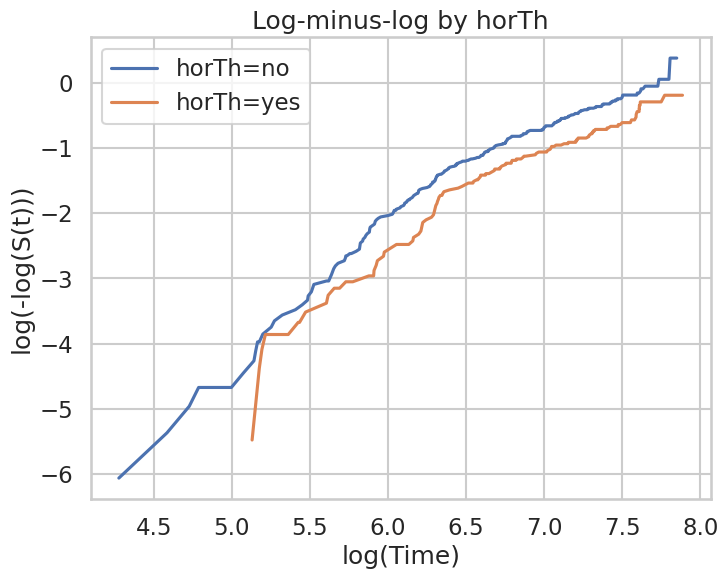

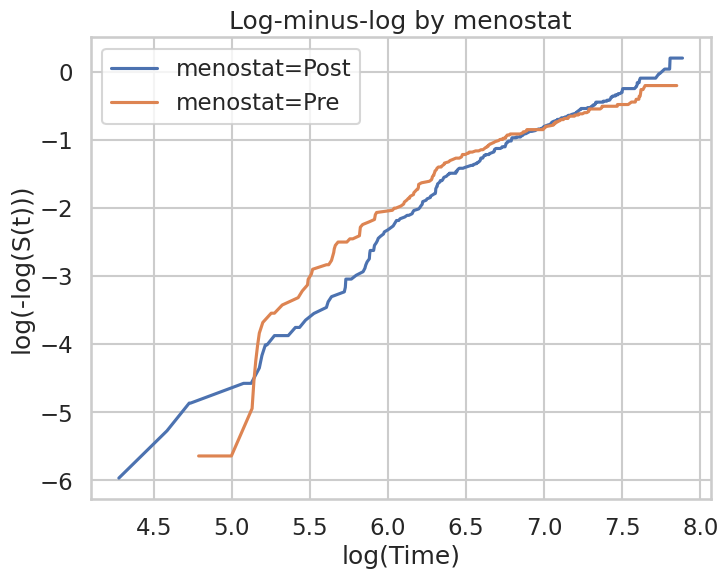

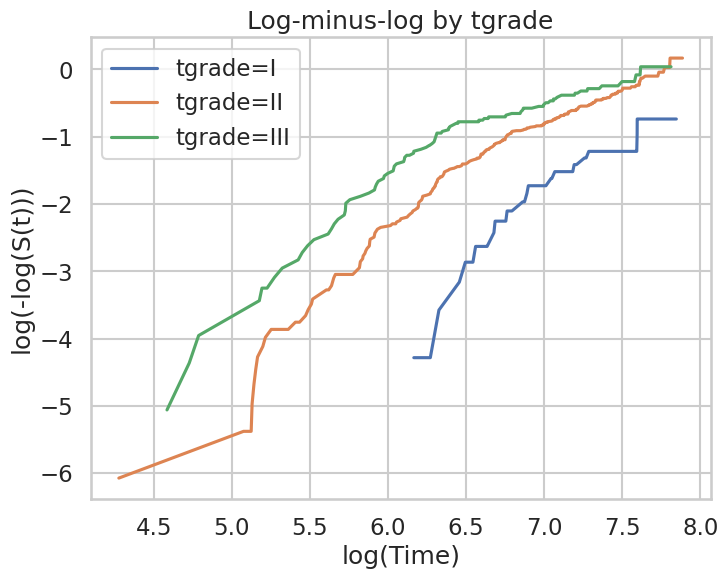

<Figure size 800x600 with 0 Axes>

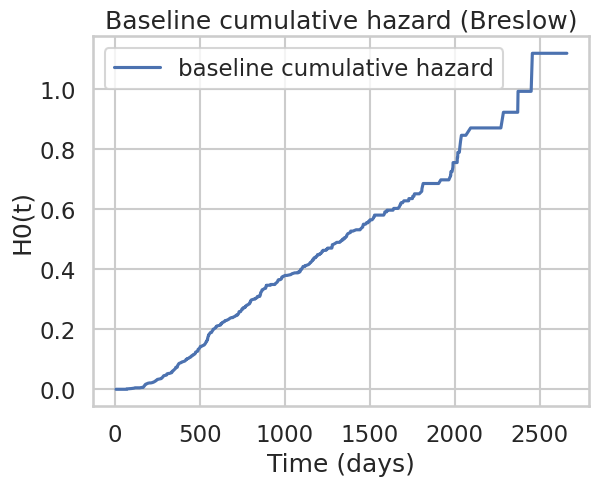

<Figure size 800x600 with 0 Axes>

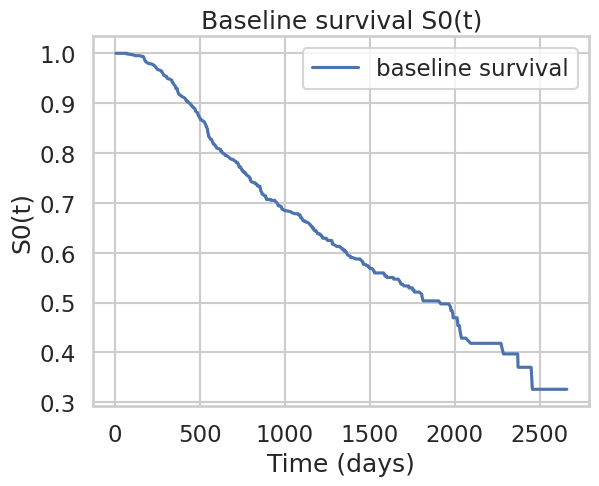

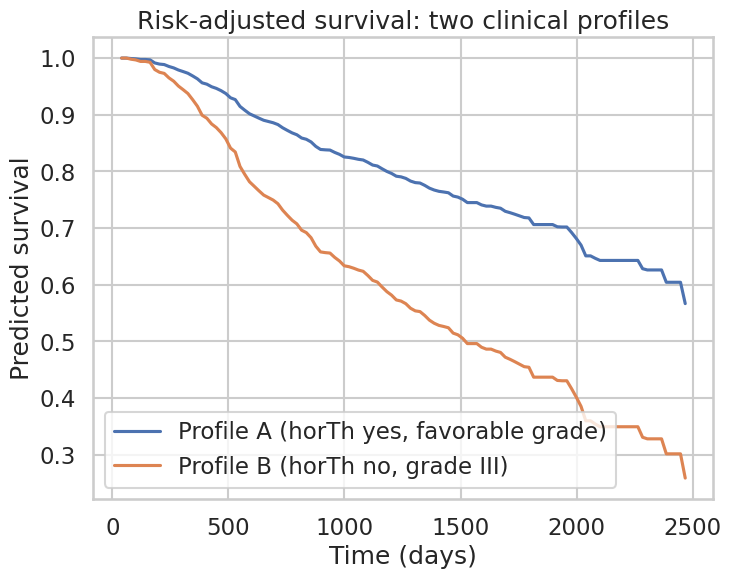


Concordance index (apparent): 0.6919

C-index summary:
+----+--------------+------------+---------------+
|    |   C_apparent |   optimism |   C_corrected |
|----+--------------+------------+---------------|
|  0 |       0.6919 |     0.0108 |        0.6810 |
+----+--------------+------------+---------------+

Approx. Integrated Brier Score over grid: 0.18052496286866232


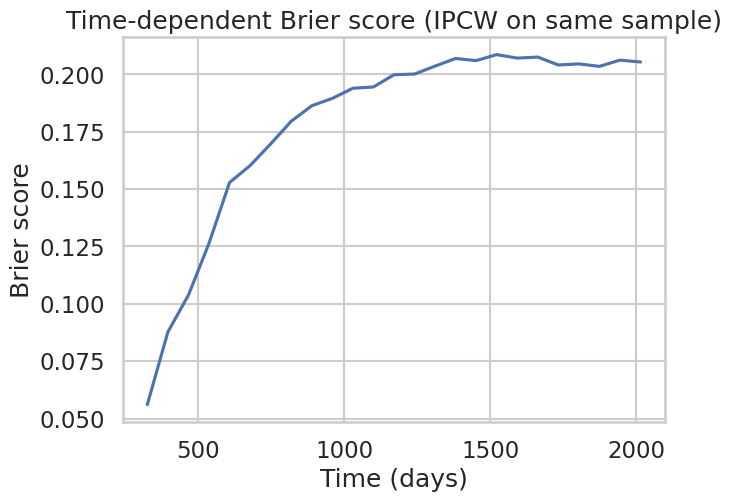


Elastic-net Cox (Coxnet) 5-fold CV C-index by l1_ratio [predict()-based]:
+----+------------+-------------+
|    |   l1_ratio |   cv_cindex |
|----+------------+-------------|
|  0 |     0.1000 |      0.3242 |
|  1 |     0.5000 |      0.3243 |
|  2 |     0.9000 |      0.3243 |
+----+------------+-------------+

Elastic-net (example lambda) nonzero coefficients (sorted by magnitude):
+----+--------------+---------+
|    | feature      |    coef |
|----+--------------+---------|
|  0 | pnodes       |  0.2657 |
|  1 | tgrade_III   |  0.1493 |
|  2 | tgrade_II    |  0.1030 |
|  3 | tsize        |  0.0847 |
|  4 | menostat_Pre | -0.0212 |
|  5 | horTh_yes    | -0.1259 |
|  6 | progrec      | -0.3629 |
+----+--------------+---------+

All outputs saved under 'outputs/' and zipped as 'GBSG2_outputs.zip'.

Saved figures:
  - outputs/figs/baseline_cumhaz.png
  - outputs/figs/baseline_survival.png
  - outputs/figs/brier_score.png
  - outputs/figs/km_by_horTh.png
  - outputs/figs/km_overall.png


In [14]:
# ============================
# Colab setup & dependencies
# ============================
!pip -q install pandas numpy seaborn matplotlib lifelines scikit-survival tabulate scikit-learn

import os, zipfile, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.utils import concordance_index

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tabulate import tabulate

from sksurv.util import Surv
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, brier_score

warnings.filterwarnings("ignore")
sns.set(context="talk", style="whitegrid")

# ============================
# File & output directories
# ============================
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figs")
TAB_DIR = os.path.join(OUT_DIR, "tables")
for d in [OUT_DIR, FIG_DIR, TAB_DIR]:
    os.makedirs(d, exist_ok=True)

def savefig(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()

def save_table(df: pd.DataFrame, name: str):
    csv_path = os.path.join(TAB_DIR, f"{name}.csv")
    xlsx_path = os.path.join(TAB_DIR, f"{name}.xlsx")
    df.to_csv(csv_path, index=False)
    try:
        df.to_excel(xlsx_path, index=False)
    except Exception:
        pass
    return csv_path

# ============================
# Load data (prefers your uploaded CSV)
# ============================
candidates = [
    "GBSG2_epidemiology.csv",                 # typical Colab working dir
    "/content/GBSG2_epidemiology.csv",        # explicit Colab path
    "/mnt/data/GBSG2_epidemiology.csv",       # fallback (if tool uploaded here)
]
csv_path = next((p for p in candidates if os.path.exists(p)), None)

if csv_path:
    df = pd.read_csv(csv_path)
    print(f"Loaded CSV: {csv_path}")
else:
    print("CSV not found, falling back to sksurv.datasets.load_gbsg2()")
    X, y = load_gbsg2()
    df = pd.DataFrame(X)
    # sksurv: y['cens'] = True means event (death) occurred
    df["event"] = y["cens"].astype(bool)
    df["time"]  = y["time"].astype(float)

# Clean column names
df.columns = [c.replace(".", "_") for c in df.columns]

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nHead:")
print(df.head())

# ============================
# Basic typing and variable sets
# ============================
cont_vars = [v for v in ["age", "tsize", "pnodes", "estrec", "progrec"] if v in df.columns]
grade_col = "grade" if "grade" in df.columns else ("tgrade" if "tgrade" in df.columns else None)

cat_vars = []
if "horTh" in df.columns: cat_vars.append("horTh")
if "menostat" in df.columns: cat_vars.append("menostat")
if grade_col is not None:   cat_vars.append(grade_col)

# Ensure categorical types (strings like "yes/no", "Pre/Post", "I/II/III")
for c in cat_vars:
    df[c] = df[c].astype("category")

# Drop rows with missing essentials
df = df.dropna(subset=["time", "event"])
df = df[df["time"] > 0]

# ============================
# Kaplan–Meier: overall & by hormonal therapy
# ============================
kmf = KaplanMeierFitter()

fig = plt.figure(figsize=(8,6))
kmf.fit(df["time"], event_observed=df["event"], label="All patients")
kmf.plot(ci_show=True)
plt.title("Kaplan–Meier: Overall Survival")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
savefig(os.path.join(FIG_DIR, "km_overall.png"))

if "horTh" in df.columns and df["horTh"].nunique() > 1:
    fig = plt.figure(figsize=(8,6))
    for grp, sub in df.groupby("horTh"):
        kmf.fit(sub["time"], sub["event"], label=f"horTh={grp}")
        kmf.plot(ci_show=False)
    plt.title("Kaplan–Meier by Hormonal Therapy")
    plt.xlabel("Time (days)"); plt.ylabel("Survival probability")
    savefig(os.path.join(FIG_DIR, "km_by_horTh.png"))

    levels = list(df["horTh"].cat.categories if hasattr(df["horTh"], "cat") else df["horTh"].unique())
    if len(levels) == 2:
        g0 = df[df["horTh"] == levels[0]]
        g1 = df[df["horTh"] == levels[1]]
        lr = logrank_test(g0["time"], g1["time"], event_observed_A=g0["event"], event_observed_B=g1["event"])
        print("\nLogrank test by horTh:")
        print(lr.summary)

# ============================
# Prepare data for CoxPH (lifelines)
# ============================
use_vars = cont_vars + cat_vars
model_df = df[["time", "event"] + use_vars].dropna()

# One-hot encode categoricals (drop first)
model_df = pd.get_dummies(model_df, columns=cat_vars, drop_first=True)

# Scale continuous features
scaler = StandardScaler()
for v in cont_vars:
    if v in model_df.columns:
        model_df[v] = scaler.fit_transform(model_df[[v]])

# Fit Cox PH (Efron ties is default), robust SE
cph = CoxPHFitter()
cph.fit(model_df, duration_col="time", event_col="event", robust=True)

print("\n=== Cox PH Summary ===")
cox_summary = cph.summary.reset_index().rename(columns={"index":"covariate"})
print(tabulate(cox_summary, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(cox_summary, "coxph_summary")

# HR table
hr_table = cph.summary.copy()
hr_table["HR"] = np.exp(hr_table["coef"])
hr_table["HR_CI_lower"] = np.exp(hr_table["coef lower 95%"])
hr_table["HR_CI_upper"] = np.exp(hr_table["coef upper 95%"])
hr_table = hr_table[["coef","se(coef)","z","p","HR","HR_CI_lower","HR_CI_upper","exp(coef)"]]
hr_table = hr_table.rename(columns={"exp(coef)":"exp_coef_(=HR_check)"})
print("\n=== Hazard Ratios (exp(coef)) with 95% CI ===")
print(tabulate(hr_table.reset_index().rename(columns={"index":"covariate"}), headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(hr_table.reset_index().rename(columns={"index":"covariate"}), "coxph_HR_table")

# ============================
# PH diagnostics (Schoenfeld)
# ============================
print("\n=== Proportional Hazards tests (Schoenfeld residual-based) ===")
resPH = proportional_hazard_test(cph, model_df, time_transform="rank")
ph_table = resPH.summary.reset_index().rename(columns={"index":"variable"})
print(tabulate(ph_table, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(ph_table, "ph_test_schoenfeld")

# ============================
# Log-minus-log plots (by categorical)
# ============================
def log_minus_log_plot(df_in, time_col, event_col, group_col, fname):
    fig = plt.figure(figsize=(8,6))
    for lvl, sub in df_in.groupby(group_col):
        km = KaplanMeierFitter().fit(sub[time_col], sub[event_col], label=str(lvl))
        s = km.survival_function_.iloc[:, 0].clip(lower=1e-9, upper=1.0)
        t = km.survival_function_.index.values
        plt.plot(np.log(t + 1e-6), np.log(-np.log(s)), label=f"{group_col}={lvl}")
    plt.xlabel("log(Time)"); plt.ylabel("log(-log(S(t)))")
    plt.title(f"Log-minus-log by {group_col}")
    plt.legend()
    plt.show()
    savefig(os.path.join(FIG_DIR, fname))

for g in [col for col in ["horTh", "menostat", grade_col] if (col in df.columns and df[col].nunique() > 1)]:
    try:
        log_minus_log_plot(df, "time", "event", g, f"logminuslog_{g}.png")
    except Exception:
        pass

# ============================
# Residuals: martingale & deviance
# ============================
mart_res = cph.compute_residuals(model_df, kind="martingale")
dev_res  = cph.compute_residuals(model_df, kind="deviance")

def save_residuals_long(res_df: pd.DataFrame, value_col_name: str, base_name: str):
    r = res_df.copy().reset_index(names="row")
    if r.shape[1] == 2:
        valcol = [c for c in r.columns if c not in ["row"]][0]
        r = r.rename(columns={valcol: value_col_name})
    else:
        r = r.melt(id_vars=["row"], var_name="var", value_name=value_col_name)
    save_table(r, base_name)
    return r

mart_long = save_residuals_long(mart_res, "martingale_resid", "residuals_martingale_long")
dev_long  = save_residuals_long(dev_res,  "deviance_resid",   "residuals_deviance_long")

for v in cont_vars:
    if v in model_df.columns and v in mart_res.columns:
        fig = plt.figure(figsize=(7,5))
        plt.scatter(model_df[v], mart_res[v], s=12, alpha=0.6)
        sns.regplot(x=model_df[v], y=mart_res[v], lowess=True, scatter=False)
        plt.axhline(0, ls="--", lw=1, c="k")
        plt.title(f"Martingale residuals vs {v} (linearity check)")
        plt.xlabel(f"{v} (scaled)"); plt.ylabel("Martingale residual")
        plt.show()
        savefig(os.path.join(FIG_DIR, f"martingale_vs_{v}.png"))

# ============================
# Baseline hazard/survival
# ============================
fig = plt.figure(figsize=(8,6))
cph.baseline_cumulative_hazard_.plot()
plt.title("Baseline cumulative hazard (Breslow)")
plt.xlabel("Time (days)"); plt.ylabel("H0(t)")
plt.show()
savefig(os.path.join(FIG_DIR, "baseline_cumhaz.png"))

fig = plt.figure(figsize=(8,6))
cph.baseline_survival_.plot()
plt.title("Baseline survival S0(t)")
plt.xlabel("Time (days)"); plt.ylabel("S0(t)")
plt.show()
savefig(os.path.join(FIG_DIR, "baseline_survival.png"))

# ============================
# Risk-adjusted survival: two clinical profiles (FIXED PLOT)
# ============================
template = model_df.drop(columns=["time","event"]).median(numeric_only=True).to_frame().T
template = template.reindex(columns=model_df.drop(columns=["time","event"]).columns, fill_value=0)

def set_if_exists(dfX, name, val):
    if name in dfX.columns:
        dfX.loc[:, name] = val

prof_good = template.copy()
set_if_exists(prof_good, "horTh_yes", 1)
set_if_exists(prof_good, "menostat_Pre", 0)
if grade_col:
    set_if_exists(prof_good, f"{grade_col}_II", 0)
    set_if_exists(prof_good, f"{grade_col}_III", 0)

prof_bad = template.copy()
set_if_exists(prof_bad, "horTh_yes", 0)
set_if_exists(prof_bad, "menostat_Pre", 1)
if grade_col:
    set_if_exists(prof_bad, f"{grade_col}_III", 1)
    set_if_exists(prof_bad, f"{grade_col}_II", 0)

times = np.linspace(model_df["time"].quantile(0.01),
                    model_df["time"].quantile(0.99), 120)

sf_good = cph.predict_survival_function(prof_good, times=times)  # (len(times), 1)
sf_bad  = cph.predict_survival_function(prof_bad , times=times)
x = sf_good.index.to_numpy(dtype=float)
y_good = sf_good.iloc[:, 0].to_numpy()
y_bad  = sf_bad.iloc[:, 0].to_numpy()

plt.figure(figsize=(8,6))
plt.plot(x, y_good, label="Profile A (horTh yes, favorable grade)")
plt.plot(x, y_bad , label="Profile B (horTh no, grade III)")
plt.xlabel("Time (days)"); plt.ylabel("Predicted survival")
plt.title("Risk-adjusted survival: two clinical profiles")
plt.legend()
plt.show()
savefig(os.path.join(FIG_DIR, "predicted_survival_profiles.png"))

# ============================
# Discrimination: C-index
# ============================
ci = concordance_index(event_times=model_df["time"].values,
                       predicted_scores=-cph.predict_partial_hazard(model_df),
                       event_observed=model_df["event"].values)
print(f"\nConcordance index (apparent): {ci:.4f}")

# Bootstrap optimism-corrected C-index
rng = np.random.default_rng(42)
B = 200
cindex_boot, cindex_test = [], []
for b in range(B):
    idx = rng.integers(0, len(model_df), size=len(model_df))
    boot = model_df.iloc[idx].copy()
    cox_b = CoxPHFitter()
    cox_b.fit(boot, duration_col="time", event_col="event")
    c_app = concordance_index(boot["time"], -cox_b.predict_partial_hazard(boot), boot["event"])
    cindex_boot.append(c_app)
    c_test = concordance_index(model_df["time"], -cox_b.predict_partial_hazard(model_df), model_df["event"])
    cindex_test.append(c_test)

optimism = float(np.mean(cindex_boot) - np.mean(cindex_test))
c_corrected = float(ci - optimism)
cix_df = pd.DataFrame({"C_apparent":[ci], "optimism":[optimism], "C_corrected":[c_corrected]})
print("\nC-index summary:")
print(tabulate(cix_df, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(cix_df, "cindex_summary")

# ============================
# Time-dependent Brier score (using survival probs)
# ============================
y_struct = Surv.from_arrays(event=model_df["event"].astype(bool).values,
                            time=model_df["time"].astype(float).values)

t_grid = np.linspace(np.percentile(model_df["time"], 10),
                     np.percentile(model_df["time"], 90), 25)

surv_mat = []
X_only = model_df.drop(columns=["time","event"])
for i in range(len(model_df)):
    sf = cph.predict_survival_function(X_only.iloc[[i]], times=t_grid)
    surv_mat.append(sf.values.ravel())
surv_mat = np.vstack(surv_mat)

_, bs = brier_score(y_struct, y_struct, surv_mat, t_grid)
brier_df = pd.DataFrame({"time": t_grid, "brier": bs})
print("\nApprox. Integrated Brier Score over grid:",
      np.trapz(bs, t_grid) / (t_grid[-1] - t_grid[0]))
save_table(brier_df, "brier_scores")

fig = plt.figure(figsize=(7,5))
plt.plot(t_grid, bs)
plt.xlabel("Time (days)"); plt.ylabel("Brier score")
plt.title("Time-dependent Brier score (IPCW on same sample)")
plt.show()
savefig(os.path.join(FIG_DIR, "brier_score.png"))

# ============================
# Elastic-net Cox (Coxnet) with CV  [NO matmul, uses predict()]
# ============================
X_df = model_df.drop(columns=["time","event"])
feature_names = X_df.columns.tolist()

scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X_df.values)

alphas = [0.1, 0.5, 0.9]  # l1_ratio values
results_en = []
best_model, best_c, best_l1 = None, -np.inf, None

kf = KFold(n_splits=5, shuffle=True, random_state=123)
for a in alphas:
    fold_cs = []
    for tr, te in kf.split(X_scaled):
        model = CoxnetSurvivalAnalysis(l1_ratio=a)
        model.fit(X_scaled[tr], y_struct[tr])

        # Predict validation scores for ALL lambdas -> (n_te, n_lambdas)
        scores_all = model.predict(X_scaled[te])
        scores_all = np.asarray(scores_all)
        if scores_all.ndim == 1:          # when only 1 lambda on the path
            scores_all = scores_all.reshape(-1, 1)  # (n_te, 1)


        c_per_lambda = [
            concordance_index_censored(
                y_struct[te]["event"], y_struct[te]["time"], -scores_all[:, j]
            )[0]
            for j in range(scores_all.shape[1])
        ]
        fold_cs.append(float(np.max(c_per_lambda)))


    avg_c = float(np.mean(fold_cs))
    results_en.append({"l1_ratio": a, "cv_cindex": avg_c})
    if avg_c > best_c:
        best_c  = avg_c
        best_l1 = a
        best_model = CoxnetSurvivalAnalysis(l1_ratio=a).fit(X_scaled, y_struct)

en_df = pd.DataFrame(results_en)
print("\nElastic-net Cox (Coxnet) 5-fold CV C-index by l1_ratio [predict()-based]:")
print(tabulate(en_df, headers="keys", tablefmt="psql", floatfmt=".4f"))
save_table(en_df, "coxnet_cv_summary")

# Nonzero features at a mid-path lambda (handle coef_ orientation safely)
if best_model is not None:
    coef = np.asarray(best_model.coef_)
    nfeat = len(feature_names)

    if coef.ndim == 2:
        # layout can be (n_features, n_lambdas) or (n_lambdas, n_features)
        if coef.shape[0] == nfeat:      # (n_features, n_lambdas)
            mid_idx = coef.shape[1] // 2
            beta_vec = coef[:, mid_idx]
        else:                           # (n_lambdas, n_features)
            mid_idx = coef.shape[0] // 2
            beta_vec = coef[mid_idx, :]
    else:  # (n_features,)
        beta_vec = coef

    beta = pd.Series(beta_vec, index=feature_names, name="coef")
    nz = beta[beta.abs() > 1e-8].sort_values(ascending=False)
    nz_df = nz.reset_index().rename(columns={"index": "feature"})
    print("\nElastic-net (example lambda) nonzero coefficients (sorted by magnitude):")
    print(tabulate(nz_df, headers="keys", tablefmt="psql", floatfmt=".4f"))
    save_table(nz_df, "coxnet_nonzero_coef")

# ============================
# Zip all outputs
# ============================
zip_path = "GBSG2_outputs.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUT_DIR):
        for f in files:
            fp = os.path.join(root, f)
            z.write(fp, arcname=os.path.relpath(fp, start=OUT_DIR))
print(f"\nAll outputs saved under '{OUT_DIR}/' and zipped as '{zip_path}'.")

# ============================
# Console recap (paths)
# ============================
print("\nSaved figures:")
for f in sorted(os.listdir(FIG_DIR)):
    print("  -", os.path.join(FIG_DIR, f))

print("\nSaved tables:")
for f in sorted(os.listdir(TAB_DIR)):
    print("  -", os.path.join(TAB_DIR, f))

print("\nZip archive:", zip_path)